# Assignment 4

In [1]:
%matplotlib notebook

import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [3]:
def graph_identification():
    
    methods = []
    
    # Determine graph algorithms
    for G in P1_Graphs:
        clustering = nx.average_clustering(G)
        shortest_path = nx.average_shortest_path_length(G)
        degree_hist = nx.degree_histogram(G)
        if len(degree_hist)>10:
            methods.append('PA')
        elif clustering < 0.1:
            methods.append('SW_H')
        else:
            methods.append('SW_L')
            
    return methods

In [4]:
graph_identification()

['PA', 'PA', 'SW_L', 'PA', 'PA']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [5]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


<IPython.core.display.Javascript object>


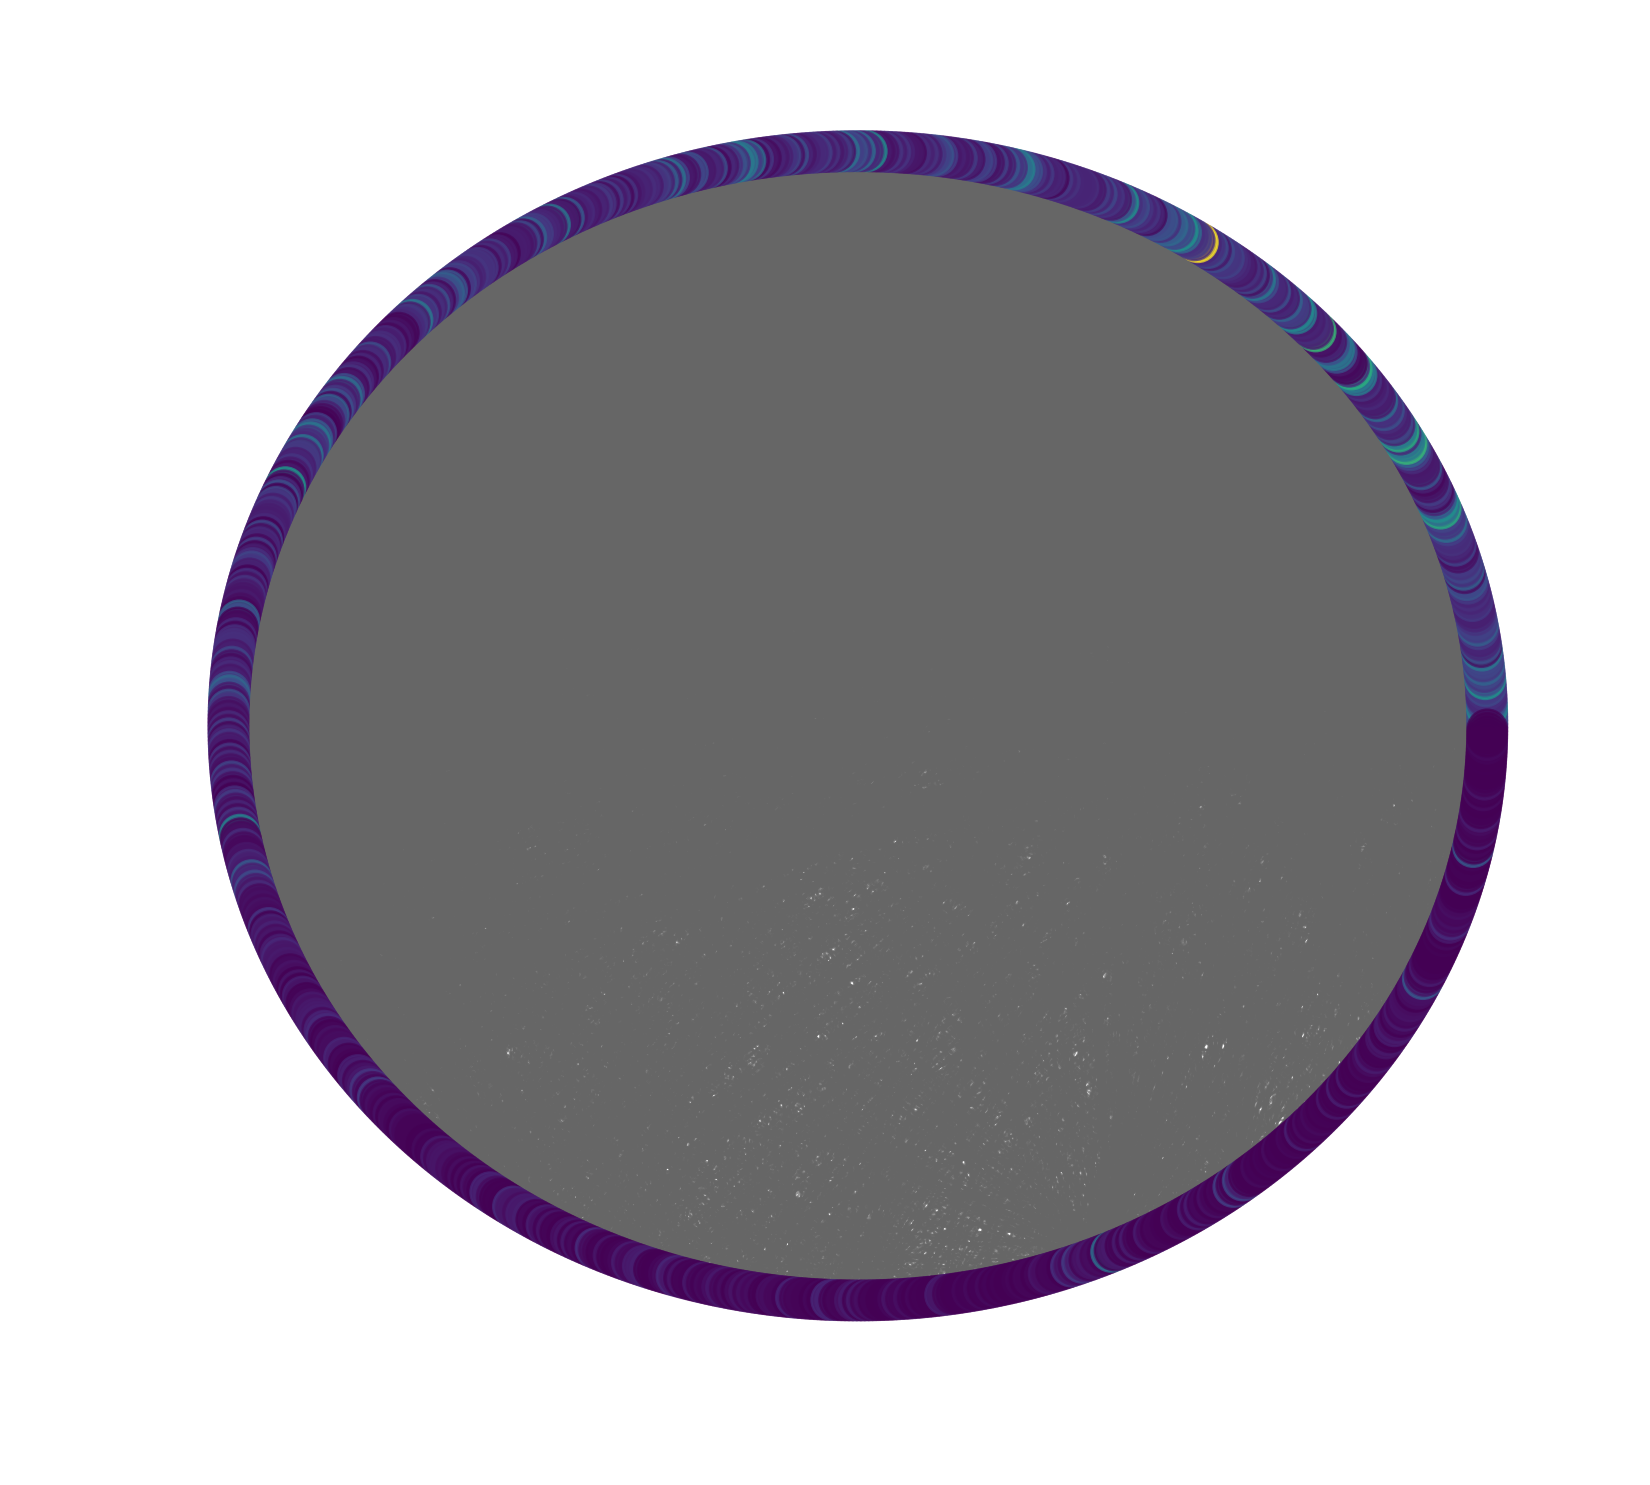

In [12]:
plt.figure(figsize=(10,9))
pos = nx.shell_layout(G)
node_color = [G.degree(v) for v in G]

nx.draw_networkx(G, pos, alpha=0.7, with_labels=False, edge_color='.4', node_color=node_color)

plt.axis('off')
plt.tight_layout();

### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [7]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

def salary_predictions():
    
    # Check if employee receives management salary
    def is_management(node):
        managementSalary = node[1]['ManagementSalary']
        if managementSalary == 0:
            return 0
        elif managementSalary == 1:
            return 1
        else:
            return None
    
    # Create dataframe
    df = pd.DataFrame(index=G.nodes())
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
    df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
    df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
    df['pr'] = pd.Series(nx.pagerank(G))
    df['is_management'] = pd.Series([is_management(node) for node in G.nodes(data=True)])
    df_train = df[~pd.isnull(df['is_management'])]
    df_test = df[pd.isnull(df['is_management'])]
    
    features = ['clustering', 'degree', 'degree_centrality', 'closeness', 'betweeness', 'pr']
    
    # Extract data
    X_train = df_train[features]
    Y_train = df_train['is_management']
    X_test = df_test[features]
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Classifier
    clf = MLPClassifier(hidden_layer_sizes = [10, 5], alpha = 5,
                       random_state = 0, solver='lbfgs', verbose=0)
    clf.fit(X_train_scaled, Y_train)
    
    # Predictions
    test_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    return pd.Series(test_proba,X_test.index)

In [8]:
salary_predictions()

1       0.128439
2       0.586261
5       0.979859
8       0.133702
14      0.304625
18      0.208766
27      0.269586
30      0.336144
31      0.169191
34      0.143513
37      0.096221
40      0.195036
45      0.162267
54      0.249954
55      0.252905
60      0.176908
62      0.992842
65      0.551284
77      0.078478
79      0.132108
97      0.099812
101     0.057517
103     0.214342
108     0.122930
113     0.454489
122     0.044350
141     0.396296
142     0.863703
144     0.072049
145     0.419966
          ...   
913     0.045734
914     0.078520
915     0.002087
918     0.144304
923     0.035175
926     0.090079
931     0.055969
934     0.013933
939     0.011147
944     0.002353
945     0.039608
947     0.162715
950     0.098173
951     0.038313
953     0.027345
959     0.002922
962     0.002440
963     0.139886
968     0.110279
969     0.104672
974     0.095061
984     0.012668
987     0.110375
989     0.113364
991     0.116944
992     0.003956
994     0.003077
996     0.0024

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [9]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

def new_connections_predictions():
    for node in G.nodes():
        G.node[node]['community'] = G.node[node]['Department']
    
    # Create dataframe
    preferential_attachment = list(nx.preferential_attachment(G))
    df = pd.DataFrame(index=[(x[0], x[1]) for x in preferential_attachment])
    df['preferential_attachment'] = [x[2] for x in preferential_attachment]
    cn_soundarajan_hopcroft = list(nx.cn_soundarajan_hopcroft(G))
    df_cn_soundarajan_hopcroft = pd.DataFrame(index=[(x[0], x[1]) for x in cn_soundarajan_hopcroft])
    df_cn_soundarajan_hopcroft['cn_soundarajan_hopcroft'] = [x[2] for x in cn_soundarajan_hopcroft]
    df = df.join(df_cn_soundarajan_hopcroft,how='outer')
    df['cn_soundarajan_hopcroft'] = df['cn_soundarajan_hopcroft'].fillna(value=0)
    df['resource_allocation_index'] = [x[2] for x in list(nx.resource_allocation_index(G))]
    df['jaccard_coefficient'] = [x[2] for x in list(nx.jaccard_coefficient(G))]
    df = future_connections.join(df,how='outer')
    df_train = df[~pd.isnull(df['Future Connection'])]
    df_test = df[pd.isnull(df['Future Connection'])]
    
    features = ['cn_soundarajan_hopcroft', 'preferential_attachment', 'resource_allocation_index', 'jaccard_coefficient']
    
    # Extract data
    X_train = df_train[features]
    Y_train = df_train['Future Connection']
    X_test = df_test[features]
    
    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Classifier
    clf = MLPClassifier(hidden_layer_sizes = [10, 5], alpha = 5,
                       random_state = 0, solver='lbfgs', verbose=0)
    clf.fit(X_train_scaled, Y_train)
    
    # Predictions
    test_proba = clf.predict_proba(X_test_scaled)[:, 1]
    predictions = pd.Series(test_proba,X_test.index)
    target = future_connections[pd.isnull(future_connections['Future Connection'])]
    target['prob'] = [predictions[x] for x in target.index]
    
    return target['prob']

In [ ]:
new_connections_predictions()